In [125]:
# Importing necessary libraries for stft,perceptron

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
from scipy.spatial.distance import euclidean as eu
from scipy.spatial.distance import cosine 
import math
from scipy import signal

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import preprocessing

# Time Domain --->  Frequency Domain

# Importing Dataset

In [126]:
#Converts the eye-tracking data of the Dyslexic and Control candidates present in the data folder into lists of datafromes
#Each data frame represents the data of 1 candidate
#The entire data is converted into 2 lists:
# 1. C_data for control candidates 
# 2. D_data for dyslexic candidates
#Structure of the dataframes:
#        LX    LY    RX    RY
#    0   ..    ..    ..    .. 
#    1   ..    ..    ..    .. 
#    2   ..    ..    ..    .. 
#   ..   ..    ..    ..    .. 
#    n   ..    ..    ..    .. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# get_data()
D_path = glob.glob(r'C:\Users\aswin\Downloads\Recording Data\Dyslexic' + "\*")
C_path = glob.glob(r'C:\Users\aswin\Downloads\Recording Data\Control' + "\*")

C_data = []                                   # Reading individual Control csv files
for path in C_path:
    temp = pd.read_csv(path)
    temp = temp.drop('Unnamed: 0',axis = 1)
    C_data.append(temp)

D_data = []                                   # Reading individual Dyslexia csv files
for path in D_path:
    temp = pd.read_csv(path)
    temp = temp.drop('Unnamed: 0',axis = 1)
    D_data.append(temp)

    
#Get Control and Dyslexic data as required for the STFT operations
# get_stft_data()
C_new = []                                    # Creating a dataframe with 'LX','LY','RX','RY' and removing 0th column
for data in C_data:                           # Control
    X =data[['LX','RX']]
    Y =data[['LY','RY']]
    Xm = X.mean(axis=1)
    Ym = Y.mean(axis=1)
    f = pd.DataFrame([data.iloc[:,0],Xm,Ym])
    f = f.transpose()
    f = f.rename(columns = {'Unnamed 0': 'X', 'Unnamed 1': 'Y'})
    C_new.append(f)

D_new = []                                    # Creating a dataframe with 'LX','LY','RX','RY' and removing 0th column
for data in D_data:                           # Dyslexic
    X =data[['LX','RX']]
    Y =data[['LY','RY']]
    Xm = X.mean(axis=1)
    Ym = Y.mean(axis=1)
    f = pd.DataFrame([data.iloc[:,0],Xm,Ym])
    f = f.transpose()
    f = f.rename(columns = {'Unnamed 0': 'X', 'Unnamed 1': 'Y'})
    D_new.append(f)

In [127]:
# We take absolute value of the reading along X and Y axes

for i in range(len(C_new)):
    C_tempx = np.abs(C_new[i]['X'])
    mx = max(C_tempx)
    C_tempy = np.abs(C_new[i]['Y'])
    my= max(C_tempy)
    C_new[i]['X'] = C_new[i]['X']/np.abs(mx)
    C_new[i]['Y'] = C_new[i]['Y']/np.abs(my)
for i in range(len(D_new)):
    D_tempx = np.abs(D_new[i]['X'])
    mx = max(D_tempx)
    D_tempy = np.abs(D_new[i]['Y'])
    my= max(D_tempy)
    D_new[i]['X'] = D_new[i]['X']/np.abs(mx)
    D_new[i]['Y'] = D_new[i]['Y']/np.abs(my)   

In [128]:
# Spliiting the Control and Dyslexic data into complex, real and imaginary parts.

C_cmx = []
C_real= []
C_img=[]
for j in range(len(C_new)):
    dat = C_new[j]
    x = dat['X']
    y = dat['Y']
    t = dat['T']
    
    z=[]
    x_in=[]
    y_in=[]
    for i in range(0,x.size):
        z.append(complex(x[i],y[i]))
        x_in.append(x[i])
        y_in.append(y[i])
    
    
    C_cmx.append(z)
    C_real.append(x_in)
    C_img.append(y_in)

    
    
D_cmx = []
D_real= []
D_img=[]
for j in range(len(D_new)):
    dat = D_new[j]
    x = dat['X']
    y = dat['Y']
    t = dat['T']
    
    z=[]
    x_in=[]
    y_in=[]
    for i in range(0,x.size):
        z.append(complex(x[i],y[i]))
        x_in.append(x[i])
        y_in.append(y[i])
    D_cmx.append(z)
    D_real.append(x_in)
    D_img.append(y_in)

# STFT

# 1. Standard STFT run

In [129]:
def stft_run(n_ratio,o_ratio):

# Standard STFT Run: Returns Full Flattened Vector
# Input:
#     tmat: Input data control+dyslexic
#     n_ratio: Ratio to equalise Output length. n_ratio = Length (L)/Bin width (B)
#     o_ratio: Ratio of Bin_width to Overlap


# Zxx (Complex) Shape: t x f: Compute 2D STFT output array. 
#                             --> f: proportional to (Length of signal / Bin Width)
#                             --> t: depends on Bin Width an Overlap .... (Refer binning approach for exact calcualtion)
# C_spec (Real) Shape: t x f: Zxx converted to absolute values.


# OUTPUT:
#      vec (Real) Shape: (t*f)x1 : Flattened C_spec vector. 



    C_spec = []
    vec= []
    for j in range(len(tmat)):
        data = tmat[j]
        L= len(data)+1
        k = int((len(data) + 1)/250) # k varies from 4 to 8
        N=20
        B  = L/n_ratio
        E =B/o_ratio#round((N*B - L)/(N-1))
        nf = 2000/n_ratio
        f, t, Zxx = signal.stft(tmat[j],fs= L/250, nperseg=B,noverlap= E,nfft=nf)
        
        tot = np.abs(Zxx)**2
        
        
        C_spec.append(np.abs(Zxx)**2)
    
    vec = []
    for i in range(len(C_spec)):
        vec.append(C_spec[i])
    print(C_spec[i].shape)
    
    for i in range(len(C_spec)):
        vec[i]=vec[i].flatten()
    
    

    return vec

# 2. STFT Half Run

In [130]:
def stft_run_half(n_ratio,o_ratio,lim1,lim2):

# Calculates STFT of selected temporal bins. 
# ------------------------------------------
# |           ||||||||||||||||             |
# |           ||||||||||||||||             |
# |           ||||||||||||||||             |
# |           ||||||||||||||||             |
# |           ||||||||||||||||             |
# |           ||||||||||||||||             |
# ------------------------------------------
#           lim1            lim2

# Input:
#     tmat   : Input data control+dyslexic
#     n_ratio: Ratio to equalise Output length. n_ratio = Length (L)/Bin width (B)
#     o_ratio: Ratio of Bin_width to Overlap
#     lim1   : Lower limit of selected bins
#     lim2   : Upper limit of selected bins


# Zxx (Complex) Shape: t x f: Compute 2D STFT output array. 
#                             --> f: proportional to (Length of signal / Bin Width)
#                             --> t: depends on Bin Width an Overlap .... (Refer binning approach for exact calcualtion)
# C_spec (Real) Shape: t x f: Zxx converted to absolute values.


# OUTPUT:
#      vec (Real) : Flattened C_spec vector sliced by bins 




    lim1= int(lim1)
    lim2= int(lim2)
    C_spec = []
    vec= []
    for j in range(len(tmat)):
        data = tmat[j]
        L= len(data)+1
        k = int((len(data) + 1)/250) # k varies from 4 to 8
        N=20
        B  = L/n_ratio
        E =B/o_ratio#round((N*B - L)/(N-1))
        nf = 2000/n_ratio
        f, t, Zxx = signal.stft(tmat[j],fs= L/250, nperseg=B,noverlap= E,nfft=nf)
        
        tot = np.abs(Zxx)**2
        half_im=[]
        for i in range(len(tot)):
            half_im.append(tot[i][lim1:lim2])
            
        
        C_spec.append(np.asarray(half_im))
    
    vec = []
    for i in range(len(C_spec)):
        vec.append(C_spec[i])
    #print(C_spec[i].shape)
    
    for i in range(len(C_spec)):
        vec[i]=vec[i].flatten()
    
    

    return vec


# 3. STFT Frequency

In [1]:
# Flattened Vector depending on frequency

def stft_run_freq(n_ratio,o_ratio,lim1,lim2):

# Calculates STFT of selected temporal bins. 
# ------------------------------------------
# |========================================| lim2
# |========================================|
# |========================================| lim1
# |                                        |
# |                                        |
# |                                        |
# ------------------------------------------


# Input:
#     tmat   : Input data control+dyslexic
#     n_ratio: Ratio to equalise Output length. n_ratio = Length (L)/Bin width (B)
#     o_ratio: Ratio of Bin_width to Overlap
#     lim1   : Lower limit of selected frequency range
#     lim2   : Upper limit of selected frequency range


# Zxx (Complex) Shape: t x f: Compute 2D STFT output array. 
#                             --> f: proportional to (Length of signal / Bin Width)
#                             --> t: depends on Bin Width an Overlap .... (Refer binning approach for exact calcualtion)
# C_spec (Real) Shape: t x f: Zxx converted to absolute values.


# OUTPUT:
#      vec (Real) : Flattened C_spec vector sliced by frequency 




    lim1= int(lim1)
    lim2= int(lim2)
    C_spec = []
    vec= []
    for j in range(len(tmat)):
        data = tmat[j]
        L= len(data)+1
        k = int((len(data) + 1)/250) # k varies from 4 to 8
        N=20
        B  = L/n_ratio
        E =B/o_ratio#round((N*B - L)/(N-1))
        nf = 2000/n_ratio
        f, t, Zxx = signal.stft(tmat[j],fs= L/250, nperseg=B,noverlap= E,nfft=nf)
        
        tot = np.abs(Zxx)**2
        
        
        C_spec.append(np.abs(Zxx)**2)
    
    vec = []
    for i in range(len(C_spec)):
        vec.append(C_spec[i])
    print(C_spec[i].shape)
    
    factor = len(C_spec[i][3])
    l1= factor*lim1
    l2 = factor*lim2
    print(l1,l2)
    lfvec =[]
    hfvec =[]
    fvec=[]
    for i in range(len(C_spec)):
        x=vec[i].flatten()
        #print(len(x))
        #lfvec.append(x[:lim])
        #hfvec.append(x[lim:])
        fvec.append(x[l1:l2])
    
    

    return fvec

# Preparing Data before passing onto STFT ()

In [132]:
tmat=[]
for i in range(87):
    tmat.append(C_cmx[i])
for i in range(98):
    tmat.append(D_cmx[i])

In [133]:
#Labelling signals of different lengths
ylen=[]
for s in tmat:
    if(len(s)>1750):
        ylen.append(4)
    elif(len(s)>1500):
        ylen.append(3)
    elif(len(s)>1250):
        ylen.append(2)
    elif(len(s)>1000):
        ylen.append(1)
    else:
        ylen.append(0)

# Output Function

In [134]:
def final(X_train,y_train,X,y):

# Function to plot final perceptron results.

# scatter plot of all reading with heights from x-axis as distances from the separating plane.
# INPUT:
#      X_train, y_train: Training set readings and labels
# OUTPUT:
#      ht : Distances form separating plane ( +ve: Control side | -ve: Dyslexic side)
#      Perceptron Neural Network score: clf.score()

    clf.fit(X_train, y_train)
    ht = clf.decision_function(X)
    x = range(len(y))
    fig, ax = plt.subplots()
    ax.scatter(x,ht,c = ylen)
    ax.axvline(x=88, color='b', linestyle='-')
    ax.axhline(y=0, color='r', linestyle='-')
    print(clf.score(X,y))
    return ht

# Split Train and Test data for analysis

In [135]:
#Training testing data based on fixed index defined signals
def create_train_test(X,index):
    X_train=[]
    X_test=[]
    y_train=[]
    y_test=[]
    index_test =[]
    index_train=index
    for i in range(len(X)):
        if i in index_train:
            X_train.append(X[i])
            y_train.append(y[i])
        else:
            X_test.append(X[i])
            y_test.append(y[i])
            index_test.append(i)
    return X_train, X_test,y_train,y_test,index_train,index_test

In [136]:
def add_num(ind):
    r=random.randint(0,186)
    if r not in ind:
        ind.append(r)
    else:
        add_num(ind)

# Perceptron Output

# Getting Misclassified Points

In [137]:
# Function to get misclassified points

# Get misclassified points form final result 
#INPUT:
#     Res: Distances from separating plane
#  
# OUTPUT:
#      WrongClass: Array of all wrongly classified points
#                 Every element is [index, Length of reading]


def get_misclassified(res):
    WrongClass=[]
    for i in range(88):
        if(res[i]<0):
            WrongClass.append([i,ylen[i]])
    for i in range(88,185):
        if(res[i]>0):
            WrongClass.append([i,ylen[i]])
    return WrongClass
    

In [138]:
def misc_pts(misc):
    dp=[]
    for i in misc:
        dp.append(i[0])
    print(dp)

# Final Output

In [139]:
# Importing the necessary libraries for building neural network and k-means clustering

from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

# Creating instance of Perceptron to be used for Neural Network
clf = Perceptron(tol=1e-3, random_state=0)
y= np.concatenate((np.ones(87), np.zeros(98)))

In [140]:
# K-Means Clustering

from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=2)

In [141]:
import random
index=[]
for i in range(130):
    add_num(index)

In [142]:
len(index)

130

In [143]:
# Standard STFT Run
# Returns Full Flattened Vector C_spec

In [144]:
vec = stft_run(125,2)
X = np.asarray(vec)
# Train_Test_Split
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)

# Using K-Means Classifier
y_km = Kmean.fit_predict(X)


C:\Users\aswin\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(16, 251)


In [145]:
# Accuracy Score for Standard STFT run with K-Means Classifier

accuracy_score(y, y_km)

0.4756756756756757

0.9675675675675676


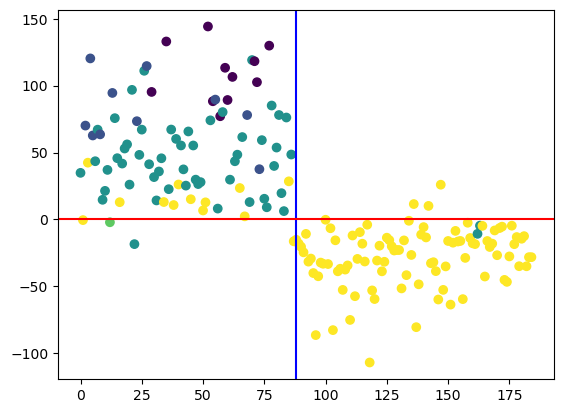

In [146]:
# Unsupervised learning method in which Perceptrons are used to build Neural Networks for prediction
# Distances from separating plane ( +ve: Control side | -ve: Dyslexic side)

res = final(X_train,y_train,X,y)

In [147]:
# 
misc1 = get_misclassified(res)

# Partial Bins

In [148]:
# Dataset is divided into groups/bins of 2

# First Half Bins        (0-124)

# K-Means Classifier
vec = stft_run_half(125,2,0,125)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
accuracy_score(y, y_km)

C:\Users\aswin\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.5081081081081081

0.9513513513513514


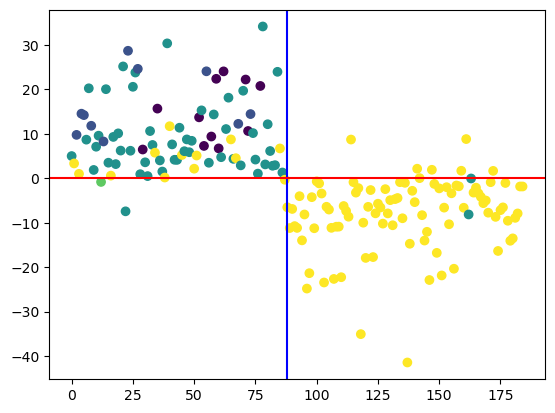

In [149]:
# Perceptron 
# Distances from separating plane ( +ve: Control side | -ve: Dyslexic side)

res = final(X_train,y_train,X,y)

In [150]:
misc2_half = get_misclassified(res)

In [151]:
#Second Half Bins    (125-250)

# K-Means Classifier
vec = stft_run_half(125,2,125,251)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
accuracy_score(y, y_km)

C:\Users\aswin\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.4702702702702703

0.972972972972973


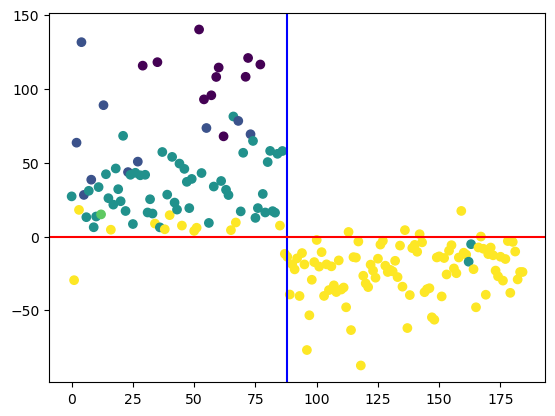

In [152]:
# Perceptron 
# Distances from separating plane ( +ve: Control side | -ve: Dyslexic side)

res = final(X_train,y_train,X,y)

In [153]:
misc2_half_r = get_misclassified(res)

# Quarter Bins

In [154]:
#First 25% (Q1) Bin     (0-62)

# K-Means Classifier
vec = stft_run_half(125,2,0,63)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
accuracy_score(y, y_km)

C:\Users\aswin\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.4972972972972973

0.9243243243243243


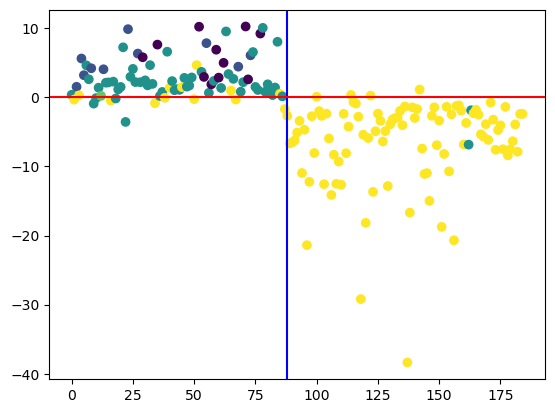

In [155]:
# Perceptron 
# Distances from separating plane ( +ve: Control side | -ve: Dyslexic side)

res = final(X_train,y_train,X,y)

In [156]:
misc2_q1 = get_misclassified(res)

C:\Users\aswin\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.5567567567567567
0.9513513513513514


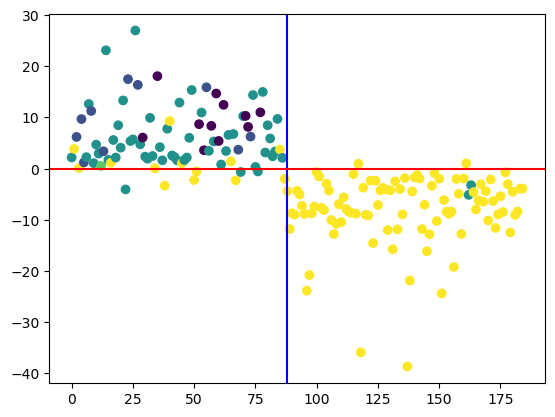

In [157]:
#Q2 Bin (25-50%)          (63-124)

vec = stft_run_half(125,2,63,125)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc2_q2 = get_misclassified(res)

C:\Users\aswin\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.4972972972972973
0.9513513513513514


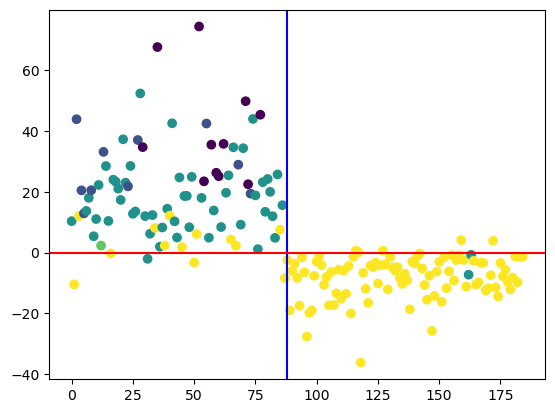

In [158]:
#Q3 Bin (50-75%)          (125-187)

vec = stft_run_half(125,2,125,188)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc2_q3 = get_misclassified(res)

C:\Users\aswin\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.5243243243243243
0.9297297297297298


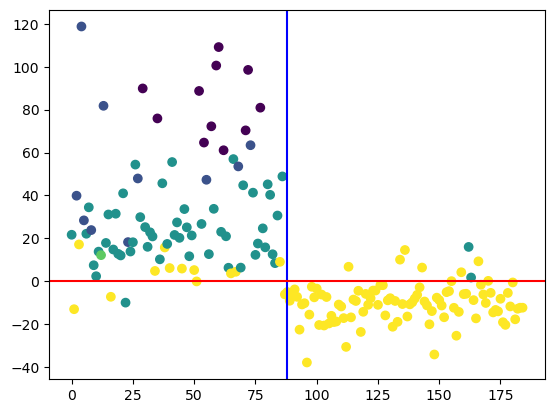

In [159]:
#Q4 Bin (75-100%)          (188-250)   

vec = stft_run_half(125,2,188,251)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
misc2_q4 = get_misclassified(res)

C:\Users\aswin\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(40, 64)
0.4810810810810811
0.9675675675675676
[[1, 4], [28, 2], [31, 2], [66, 2], [74, 2], [87, 4], [142, 4]]


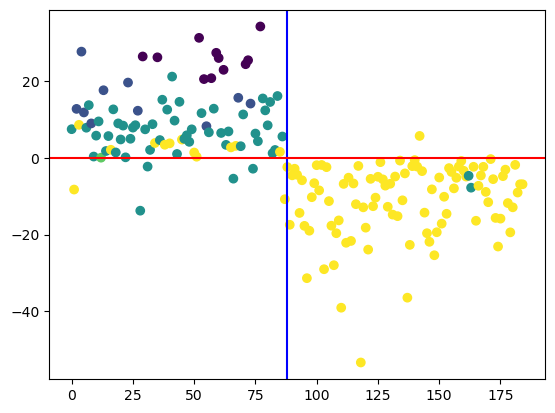

In [160]:
# Best Hyperparameters used on the model to get maximum score

# Standard STFT run
# Returns full flattened C_Spec vector
vec = stft_run(50,5)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
print(get_misclassified(res))

C:\Users\aswin\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


0.518918918918919
0.9675675675675676
[[1, 4], [28, 2], [31, 2], [66, 2], [74, 2], [87, 4], [142, 4]]


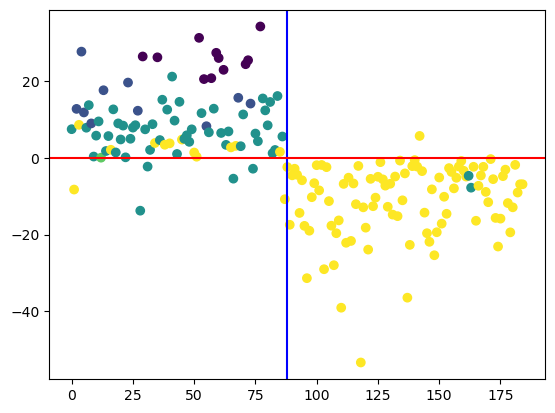

In [161]:
# Best Hyperparameters used on the model to get maximum score

# STFT run half
vec = stft_run_half(50,5,0,64)
X = np.asarray(vec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
print(get_misclassified(res))

C:\Users\aswin\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(40, 64)
0 3200
0.4810810810810811
0.9675675675675676


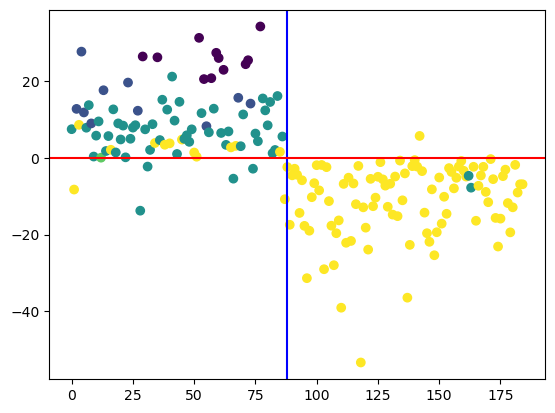

In [162]:
# Partial frequencies
# Binnning based on frequency

#Freq Div 35/40
fvec = stft_run_freq(50,5,0,50)
X = np.asarray(fvec)
X_train, X_test,y_train,y_test,index_train,index_test= create_train_test(X,index)
y_km = Kmean.fit_predict(X)
print(accuracy_score(y, y_km))
res = final(X_train,y_train,X,y)
temp = get_misclassified(res)